## Recommendation System

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

import gzip

In [2]:
# for google collab use only
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# connecting to google drive
# os.chdir('/content/drive/MyDrive/Class/DSF-FT09/Tools/IMDB/Notebooks')

In [4]:
# os.listdir()

In [5]:
def read_zipped_tsv(file_path, header=None):
    """
    Reads a zipped TSV file into a pandas DataFrame.

    Args:
        file_path (str): The path to the zipped TSV file.
        header (int, default=None): Row number to use as the column names.

    Returns:
        pandas.DataFrame: The DataFrame containing the data from the zipped TSV file.

    Raises:
        ValueError: If the file path does not point to a valid gzip file.
    """

    with gzip.open(file_path, 'rt', encoding='utf-8') as f:
        try:
            df = pd.read_csv(f, delimiter='\t', header=header)
        except OSError as e:
            if "not a gzip file" in str(e):
                raise ValueError(f"Invalid file format for {file_path}. Expected a zipped TSV file.") from e
            else:
                raise e  # Re-raise other OSError exceptions

    return df

In [6]:
names = read_zipped_tsv('../Data/name.basics.tsv.gz', header=0)

In [7]:
names.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer","tt0072308,tt0050419,tt0053137,tt0027125"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack,archive_footage","tt0037382,tt0075213,tt0117057,tt0038355"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,music_department,producer","tt0057345,tt0049189,tt0056404,tt0054452"
3,nm0000004,John Belushi,1949,1982,"actor,writer,music_department","tt0072562,tt0077975,tt0080455,tt0078723"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0083922,tt0050976,tt0069467"


In [8]:
names.shape

(13811372, 6)

In [9]:
ratings = read_zipped_tsv('../Data/title.ratings.tsv.gz', header=0)

In [10]:
ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2089
1,tt0000002,5.6,283
2,tt0000003,6.5,2092
3,tt0000004,5.4,184
4,tt0000005,6.2,2827


In [11]:
ratings.shape

(1478542, 3)

In [12]:
basic_info = read_zipped_tsv('../Data/title.basics.tsv.gz', header=0)

c:\Users\user\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3373: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  if await self.run_code(code, result, async_=asy):


In [13]:
basic_info.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,5,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [14]:
basic_info.shape

(11094642, 9)

## Data Understanding

In [15]:
names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13811372 entries, 0 to 13811371
Data columns (total 6 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   nconst             object
 1   primaryName        object
 2   birthYear          object
 3   deathYear          object
 4   primaryProfession  object
 5   knownForTitles     object
dtypes: object(6)
memory usage: 632.2+ MB


In [16]:
names.isnull().sum().sort_values(ascending=False) / len(names) * 100

primaryName          0.000029
knownForTitles       0.000000
primaryProfession    0.000000
deathYear            0.000000
birthYear            0.000000
nconst               0.000000
dtype: float64

In [17]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1478542 entries, 0 to 1478541
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   tconst         1478542 non-null  object 
 1   averageRating  1478542 non-null  float64
 2   numVotes       1478542 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 33.8+ MB


In [18]:
ratings.isnull().sum().sort_values(ascending=False) / len(names) * 100

numVotes         0.0
averageRating    0.0
tconst           0.0
dtype: float64

In [19]:
numeric_cols = ['averageRating', 'numVotes']

for col in numeric_cols:
    ratings[col] = pd.to_numeric(ratings[col], errors='coerce')

In [20]:
np.round(ratings[numeric_cols].describe(), 3)

,averageRating,numVotes
count,1478542.000,1478542.000
mean,6.961,1031.062
std,1.380,17753.387
min,1.000,5.000
25%,6.200,11.000
50%,7.200,26.000
75%,7.900,101.000
max,10.000,2942046.000


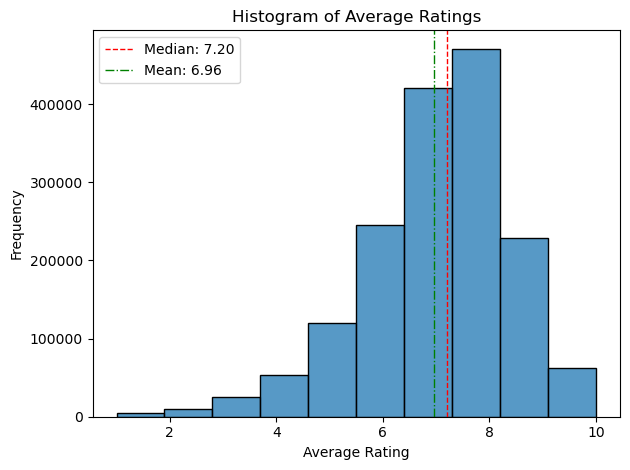

In [21]:
sns.histplot(data=ratings, x="averageRating", stat='frequency', bins=10)

median = ratings['averageRating'].median()
mean = ratings['averageRating'].mean()

plt.axvline(median, color='red', linestyle='dashed', linewidth=1, label=f'Median: {median:.2f}')
plt.axvline(mean, color='green', linestyle='dashdot', linewidth=1, label=f'Mean: {mean:.2f}')

plt.xlabel("Average Rating")
plt.ylabel("Frequency")
plt.title("Histogram of Average Ratings")
plt.legend()

plt.tight_layout()
plt.show()

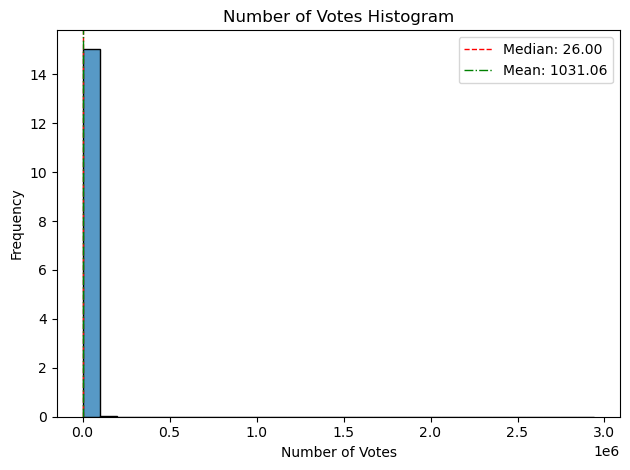

In [22]:
sns.histplot(data=ratings, x="numVotes", stat='frequency', bins=30)

median = ratings['numVotes'].median()
mean = ratings['numVotes'].mean()

plt.axvline(median, color='red', linestyle='dashed', linewidth=1, label=f'Median: {median:.2f}')
plt.axvline(mean, color='green', linestyle='dashdot', linewidth=1, label=f'Mean: {mean:.2f}')

plt.xlabel("Number of Votes")
plt.ylabel("Frequency")
plt.title("Number of Votes Histogram")
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
basic_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11094642 entries, 0 to 11094641
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   tconst          object
 1   titleType       object
 2   primaryTitle    object
 3   originalTitle   object
 4   isAdult         object
 5   startYear       object
 6   endYear         object
 7   runtimeMinutes  object
 8   genres          object
dtypes: object(9)
memory usage: 761.8+ MB


In [24]:
basic_info.isnull().sum().sort_values(ascending=False) / len(names) * 100

genres            0.004561
originalTitle     0.000087
primaryTitle      0.000087
runtimeMinutes    0.000000
endYear           0.000000
startYear         0.000000
isAdult           0.000000
titleType         0.000000
tconst            0.000000
dtype: float64

In [25]:
genres = basic_info.groupby('genres')['genres'].count()
genres = genres.sort_values(ascending=False)
print(genres.head(10))

genres
Drama             1254527
Comedy             734532
Talk-Show          685411
News               577945
Documentary        532201
Drama,Romance      515037
\N                 495799
Reality-TV         353086
Adult              311672
News,Talk-Show     248264
Name: genres, dtype: int64


In [26]:
print(genres.tail(10))

genres
Fantasy,Romance,War            1
Adventure,Film-Noir,Mystery    1
Adventure,Film-Noir,Romance    1
Fantasy,Reality-TV,Sport       1
Action,Fantasy,Reality-TV      1
Fantasy,Reality-TV,Sci-Fi      1
Adventure,Game-Show,Sci-Fi     1
Fantasy,Reality-TV,Romance     1
Music,Reality-TV,Romance       1
Fantasy,Thriller,Western       1
Name: genres, dtype: int64


In [27]:
title_type = basic_info.groupby('titleType')['titleType'].count()
title_type.sort_values(ascending=False)

titleType
tvEpisode       8510105
short           1018092
movie            692552
video            298373
tvSeries         270396
tvMovie          148503
tvMiniSeries      56804
tvSpecial         49456
videoGame         39946
tvShort           10414
tvPilot               1
Name: titleType, dtype: int64

## Data Preparation

### Missing values

In [28]:
names.dropna(subset=['primaryName'], axis=0, inplace=True)

In [29]:
basic_info.dropna(axis=0, inplace=True)

## Content-based filtering

In [30]:
# filter out movies and series
basics_filtered = basic_info[basic_info['titleType'].isin(['movie', 'tvSeries'])]

In [31]:
basics_filtered.reset_index(inplace=True, drop=True)

In [32]:
basics_filtered.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,100,"Documentary,News,Sport"
2,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
4,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama


In [33]:
basics_filtered.shape

(962948, 9)

In [34]:
# split genres into a list
basics_filtered.loc[:, 'genres'] = basics_filtered.loc[:, 'genres'].apply(lambda x: x.split(','))

c:\Users\user\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [35]:
# confirm whether above method worked
basics_filtered.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,[Romance]
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,100,"[Documentary, News, Sport]"
2,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,[\N]
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"[Action, Adventure, Biography]"
4,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,[Drama]


In [36]:
# Drop rows where genres is empty
basics_filtered = basics_filtered[basics_filtered['genres'].apply(lambda x: x != ['\\N'])]

basics_filtered.reset_index(drop=True, inplace=True)

In [37]:
# confirm whether above method worked
basics_filtered.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,[Romance]
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,100,"[Documentary, News, Sport]"
2,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"[Action, Adventure, Biography]"
3,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,[Drama]
4,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,[Drama]


In [38]:
basics_filtered = basics_filtered.drop(['originalTitle', 'endYear'], axis=1)

In [39]:
basics_filtered.head()

,tconst,titleType,primaryTitle,isAdult,startYear,runtimeMinutes,genres
0,tt0000009,movie,Miss Jerry,0,1894,45,[Romance]
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,0,1897,100,"[Documentary, News, Sport]"
2,tt0000574,movie,The Story of the Kelly Gang,0,1906,70,"[Action, Adventure, Biography]"
3,tt0000591,movie,The Prodigal Son,0,1907,90,[Drama]
4,tt0000615,movie,Robbery Under Arms,0,1907,\N,[Drama]


In [40]:
merged_df = pd.merge(basics_filtered, ratings, on='tconst', how='inner')

In [41]:
# save the merged dataframe
merged_df.to_csv('../Data/merged_df.csv', index=False)

In [42]:
# load the saved data
merged_df = pd.read_csv('../Data/merged_df.csv')

c:\Users\user\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3194: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [43]:
merged_df.head()

,tconst,titleType,primaryTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000009,movie,Miss Jerry,0,1894,45,['Romance'],5.4,214
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,0,1897,100,"['Documentary', 'News', 'Sport']",5.2,531
2,tt0000574,movie,The Story of the Kelly Gang,0,1906,70,"['Action', 'Adventure', 'Biography']",6.0,928
3,tt0000591,movie,The Prodigal Son,0,1907,90,['Drama'],5.7,28
4,tt0000615,movie,Robbery Under Arms,0,1907,\N,['Drama'],4.3,27


In [44]:
merged_df.shape

(400581, 9)

In [45]:
merged_df['runtimeMinutes'].dtype

dtype('O')

In [46]:
merged_df['runtimeMinutes'].value_counts()

\N       69619
90       19415
60       12498
30       10955
95        8667
         ...  
378          1
2880         1
990          1
51420        1
344          1
Name: runtimeMinutes, Length: 583, dtype: int64

In [47]:
merged_df_filtered = merged_df[merged_df['runtimeMinutes'] != '\\N']

In [48]:
merged_df_filtered.shape

(330962, 9)

In [49]:
merged_df_filtered['runtimeMinutes'] = merged_df_filtered['runtimeMinutes'].astype(int)

C:\Users\user\AppData\Local\Temp\ipykernel_10232\598096314.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_filtered['runtimeMinutes'] = merged_df_filtered['runtimeMinutes'].astype(int)


In [50]:
merged_df_filtered.dtypes

tconst             object
titleType          object
primaryTitle       object
isAdult             int64
startYear          object
runtimeMinutes      int32
genres             object
averageRating     float64
numVotes            int64
dtype: object

In [51]:
merged_df_filtered = merged_df_filtered.reset_index(drop='first')

In [52]:
merged_df_filtered.head()

,tconst,titleType,primaryTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000009,movie,Miss Jerry,0,1894,45,['Romance'],5.4,214
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,0,1897,100,"['Documentary', 'News', 'Sport']",5.2,531
2,tt0000574,movie,The Story of the Kelly Gang,0,1906,70,"['Action', 'Adventure', 'Biography']",6.0,928
3,tt0000591,movie,The Prodigal Son,0,1907,90,['Drama'],5.7,28
4,tt0000679,movie,The Fairylogue and Radio-Plays,0,1908,120,"['Adventure', 'Fantasy']",5.3,74


In [53]:
merged_df_filtered.shape

(330962, 9)

In [54]:
bins = [0, 30, 90, 150, float('inf')]
labels = ['short', 'Medium', 'Long', 'Very Long']

merged_df_filtered['runtimeCategory'] = pd.cut(merged_df_filtered['runtimeMinutes'], bins = bins, labels = labels, right = False)

In [55]:
# An example to showcase pandas.cut method
pd.cut(np.array([1, 7, 5, 4, 6, 3]),
       3, labels=["bad", "medium", "good"])

['bad', 'good', 'medium', 'medium', 'good', 'bad']
Categories (3, object): ['bad' < 'medium' < 'good']

In [56]:
merged_df_filtered.head()

,tconst,titleType,primaryTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,runtimeCategory
0,tt0000009,movie,Miss Jerry,0,1894,45,['Romance'],5.4,214,Medium
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,0,1897,100,"['Documentary', 'News', 'Sport']",5.2,531,Long
2,tt0000574,movie,The Story of the Kelly Gang,0,1906,70,"['Action', 'Adventure', 'Biography']",6.0,928,Medium
3,tt0000591,movie,The Prodigal Son,0,1907,90,['Drama'],5.7,28,Long
4,tt0000679,movie,The Fairylogue and Radio-Plays,0,1908,120,"['Adventure', 'Fantasy']",5.3,74,Long


In [57]:
merged_df_filtered = merged_df_filtered.sample(n=20000, random_state=42)

In [58]:
merged_df_filtered

,tconst,titleType,primaryTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,runtimeCategory
13750,tt0036533,movie,Whistling in Brooklyn,0,1943,87,"['Action', 'Comedy', 'Crime']",6.7,735,Medium
48000,tt0085155,movie,Amada,0,1983,105,['Drama'],5.8,38,Long
305618,tt6722202,movie,Guzbay New York,0,2019,90,"['Comedy', 'Drama', 'Romance']",6.7,13,Long
253863,tt29038265,movie,Pasar Setan,0,2024,96,"['Horror', 'Thriller']",6.5,45,Long
91415,tt0203234,movie,Ghost Ship Part 1,0,1957,82,"['Adventure', 'Fantasy', 'Horror']",6.7,22,Medium
...,...,...,...,...,...,...,...,...,...,...
312279,tt7430998,movie,Agam,0,2022,81,['Drama'],6.7,26,Medium
149915,tt0976132,movie,Lakshmi Kalyanam,0,2007,145,"['Action', 'Drama']",4.5,121,Long
166914,tt11725450,movie,Basta,0,2021,120,"['Comedy', 'Drama', 'Family']",7.5,157,Long
51394,tt0090575,movie,Aakhree Raasta,0,1986,164,"['Action', 'Crime', 'Drama']",7.0,1625,Very Long


In [59]:
merged_df_filtered = merged_df_filtered.reset_index(drop=True)

In [60]:
merged_df_filtered.head()

,tconst,titleType,primaryTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,runtimeCategory
0,tt0036533,movie,Whistling in Brooklyn,0,1943,87,"['Action', 'Comedy', 'Crime']",6.7,735,Medium
1,tt0085155,movie,Amada,0,1983,105,['Drama'],5.8,38,Long
2,tt6722202,movie,Guzbay New York,0,2019,90,"['Comedy', 'Drama', 'Romance']",6.7,13,Long
3,tt29038265,movie,Pasar Setan,0,2024,96,"['Horror', 'Thriller']",6.5,45,Long
4,tt0203234,movie,Ghost Ship Part 1,0,1957,82,"['Adventure', 'Fantasy', 'Horror']",6.7,22,Medium


In [61]:
movies = list(merged_df_filtered['primaryTitle'])

print(movies[:10])

['Whistling in Brooklyn', 'Amada', 'Guzbay New York', 'Pasar Setan', 'Ghost Ship Part 1', 'Senza filtro', 'Tathagatha Buddha The Life & Times of Gautama Buddha', 'Mortal Engines', 'Dead Man Working', 'The Grasslands']


#### Feature Engineering

In [62]:
# combine genre into single string
merged_df_filtered['genres_str'] = merged_df_filtered['genres'].apply(lambda x: ''.join(x))

In [63]:
merged_df_filtered.head()

,tconst,titleType,primaryTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,runtimeCategory,genres_str
0,tt0036533,movie,Whistling in Brooklyn,0,1943,87,"['Action', 'Comedy', 'Crime']",6.7,735,Medium,"['Action', 'Comedy', 'Crime']"
1,tt0085155,movie,Amada,0,1983,105,['Drama'],5.8,38,Long,['Drama']
2,tt6722202,movie,Guzbay New York,0,2019,90,"['Comedy', 'Drama', 'Romance']",6.7,13,Long,"['Comedy', 'Drama', 'Romance']"
3,tt29038265,movie,Pasar Setan,0,2024,96,"['Horror', 'Thriller']",6.5,45,Long,"['Horror', 'Thriller']"
4,tt0203234,movie,Ghost Ship Part 1,0,1957,82,"['Adventure', 'Fantasy', 'Horror']",6.7,22,Medium,"['Adventure', 'Fantasy', 'Horror']"


In [64]:
tfidf = TfidfVectorizer()

tfidf_matrix = tfidf.fit_transform(merged_df_filtered['genres_str'])

In [65]:
tfidf_matrix.shape

(20000, 32)

In [66]:
# view matrix in a dataframe

feature_names = tfidf.get_feature_names()

tf_df_output = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

tf_df_output.head()

,action,adult,adventure,animation,biography,comedy,crime,documentary,drama,family,...,romance,sci,short,show,sport,talk,thriller,tv,war,western
0,0.621948,0.0,0.000000,0.0,0.0,0.439872,0.647837,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,1.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.535079,0.000000,0.0,0.415032,0.0,...,0.735825,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.690162,0.0,0.0,0.0
4,0.000000,0.0,0.537448,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [67]:
# learn from example here

text = [
    'The cat is sitting on a mat',
    'The cat is eating food',
    'the cat is playing with toys'
]

tfidf_object = TfidfVectorizer()

matrix = tfidf_object.fit_transform(text)

feature_names = tfidf_object.get_feature_names()

tf_df = pd.DataFrame(matrix.toarray(), columns=feature_names)

tf_df

,cat,eating,food,is,mat,on,playing,sitting,the,toys,with
0,0.293607,0.000000,0.000000,0.293607,0.49712,0.49712,0.00000,0.49712,0.293607,0.00000,0.00000
1,0.338381,0.572929,0.572929,0.338381,0.00000,0.00000,0.00000,0.00000,0.338381,0.00000,0.00000
2,0.293607,0.000000,0.000000,0.293607,0.00000,0.00000,0.49712,0.00000,0.293607,0.49712,0.49712


In [68]:
# compute the cosine similarity matrix, based on TF-IDF matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [69]:
# check the shape
cosine_sim.shape

(20000, 20000)

In [70]:
scaler = MinMaxScaler()

merged_df_filtered[['averageRating_norm', 'numVotes_norm']] = scaler.fit_transform(merged_df_filtered[['averageRating', 'numVotes']])

In [71]:
merged_df_filtered[['averageRating_norm']]

,averageRating_norm
0,0.633333
1,0.533333
2,0.633333
3,0.611111
4,0.633333
...,...
19995,0.633333
19996,0.388889
19997,0.722222
19998,0.666667


In [72]:
# cosine similarities between ratings

cosine_sim_ratings = cosine_similarity(merged_df_filtered[['averageRating_norm']])

In [73]:
cosine_sim_ratings.shape

(20000, 20000)

In [74]:
# consine similarities between numvotes

cosine_sim_votes = cosine_similarity(merged_df_filtered[['numVotes_norm']])

Objective: Combine all the similarities into one.

Decide how much weight to allocate each factor.

Example:

60% Genre
30% Ratings
10% No. Votes

**Get a look at the cosine similarity matrix**

In [88]:
cosine_sim

array([[1.        , 0.        , 0.23536647, ..., 0.2072756 , 0.83951621,
        0.        ],
       [0.        , 1.        , 0.4150322 , ..., 0.36549831, 0.35514708,
        0.37177408],
       [0.23536647, 0.4150322 , 1.        , ..., 0.4038324 , 0.14739747,
        0.15429821],
       ...,
       [0.2072756 , 0.36549831, 0.4038324 , ..., 1.        , 0.12980566,
        0.1358828 ],
       [0.83951621, 0.35514708, 0.14739747, ..., 0.12980566, 1.        ,
        0.13203448],
       [0.        , 0.37177408, 0.15429821, ..., 0.1358828 , 0.13203448,
        1.        ]])

In [86]:
cosine_sim_ratings

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [87]:
cosine_sim_votes

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [89]:
# combine the similarity matrices with weights
combine_simi = (0.6 * cosine_sim) + (0.3 * cosine_sim_ratings) + (0.1 * cosine_sim_votes)

In [90]:
combine_simi.shape 

(20000, 20000)

### Recommendation Function

In [91]:
def get_recommendations(title, data, similarity_matrix=combine_simi, n=10):
    # get the index of the movie that matches the title
    idx = data[data['primaryTitle'] == title].index[0]

    # get the similarity scores for all the movies with this particular movie
    sim_scores = list(enumerate(similarity_matrix[idx]))

    # sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # get the indices of the most similar movies
    sim_scores = sim_scores[1: n+1]

    # get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # return the top n most similar movies
    return data.iloc[movie_indices][['primaryTitle', 'averageRating', 'numVotes']]

In [92]:
recommendations = get_recommendations('Guzbay New York', merged_df_filtered, n=5)
print(recommendations)

                  primaryTitle  averageRating  numVotes
22    Christmas at the Chateau            3.8       362
124  Miss Shellagh's Miniskirt            7.2        13
174            Kabaddi Kabaddi            6.5       129
470      Home for the Holidays            6.6     14684
604            The Film Critic            6.2       699


In [93]:
recommendations = get_recommendations('Mortal Engines', merged_df_filtered, n=5)
print(recommendations)

                                           primaryTitle  averageRating  \
415                                       Star Troopers            4.7   
1713                                     Tulisang pugot            5.2   
6028  Forbidden Martial Arts: The Nine Mysterious Ca...            5.5   
6902                                    Raising Dragons            6.5   
6966                                          Magma Man            7.4   

      numVotes  
415        187  
1713         8  
6028        16  
6902        16  
6966        18  
